# Modern Portfolio Theory - Cryptomarket

## Import Data

In [75]:
# basic modules
import numpy as np
import pandas as pd
import datetime as dt

In [76]:
# import data from yahoo finance
from pandas_datareader import data as pdr
def getData(assets, start, end):
    data = pdr.get_data_yahoo(assets, start = start, end = end)
    data = data["Adj Close"]
    return data

In [77]:
# select assets
data_list = ["BTC-USD", "ETH-USD", "ADA-USD", "LINK-USD", "BNB-USD"]

In [78]:
# set start and end date for data
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*3)

In [79]:
df = getData(data_list, start = startDate, end = endDate)
print(df)

Symbols          BTC-USD      ETH-USD   ADA-USD   LINK-USD     BNB-USD
Date                                                                  
2018-03-20   8913.469727   557.174988  0.204947   0.391713    9.160930
2018-03-21   8929.280273   561.731995  0.213189   0.445421    9.982000
2018-03-22   8728.469727   539.702026  0.203481   0.419292   10.066300
2018-03-23   8879.620117   539.619019  0.189259   0.409140   11.737600
2018-03-24   8668.120117   526.439026  0.189201   0.419085   13.089100
...                  ...          ...       ...        ...         ...
2021-03-15  55907.199219  1791.702271  1.033539  27.491762  254.660828
2021-03-16  56804.902344  1806.971802  1.242953  27.917419  258.100677
2021-03-17  58870.894531  1823.449341  1.378673  31.009760  269.854858
2021-03-18  57858.921875  1782.855103  1.239006  29.504812  261.704803
2021-03-19  59001.832031  1819.113525  1.282094  30.132732  267.334290

[1091 rows x 5 columns]


## Data Exploration

Comparing distributions of asset returns and checking for skewness and kurtosis.

Skewness: $\frac{1}{n}\sum^{n}_{t=1}\frac{(r_{t}-\bar{r})^3}{s^3}$, Kurtosis: $\frac{1}{n}\sum^{n}_{t=1}\frac{(r_{t}-\bar{r})^4}{s^4}$

In [80]:
# set style for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib.pyplot import plot

%matplotlib inline
# use higher resolution for plots
%config InlineBackend.figure_format = "retina"

import scipy.stats as stats

In [81]:
def multiPlot(asset):
    # distribution plot using simple returns
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
    sns.histplot(df[asset].pct_change().iloc[1:], ax = ax[0], bins = 30, color = "lightcyan", stat = "density")
    sns.kdeplot(df[asset].pct_change().iloc[1:], ax = ax[0], color = "blue", linestyle = "--", label = "Kernel Density")
    ax[0].set_xlim(-0.3, 0.3)
    ax[0].set_xlabel("Simple Returns")
    ax[0].set_title("Histogram of simple returns")
    
    # compute normal distribution for comparison
    mu, std = stats.norm.fit(df[asset].pct_change().iloc[1:])
    x = np.linspace(-0.3, 0.3, 300)
    p = stats.norm.pdf(x, mu, std)
    ax[0].plot(x, p, "r", linewidth = 2, label = "Normal")
    ax[0].legend()

    # qq-plot
    stats.probplot(df[asset].pct_change().iloc[1:], dist = "norm", 
               rvalue = True, fit = True, plot = plt)
    plt.xlabel("Normal Distribution")
    plt.ylabel("Sample Distribution")

Recall that a normal distribution in the form of $f(x)=\frac{1}{\sigma \sqrt{2\pi}}\exp\left[ -\frac{(x-\mu)^2}{2\sigma^2} \right]$ has a skewness of 0 and a kurtosis of 3.

### Bitcoin (BTC)

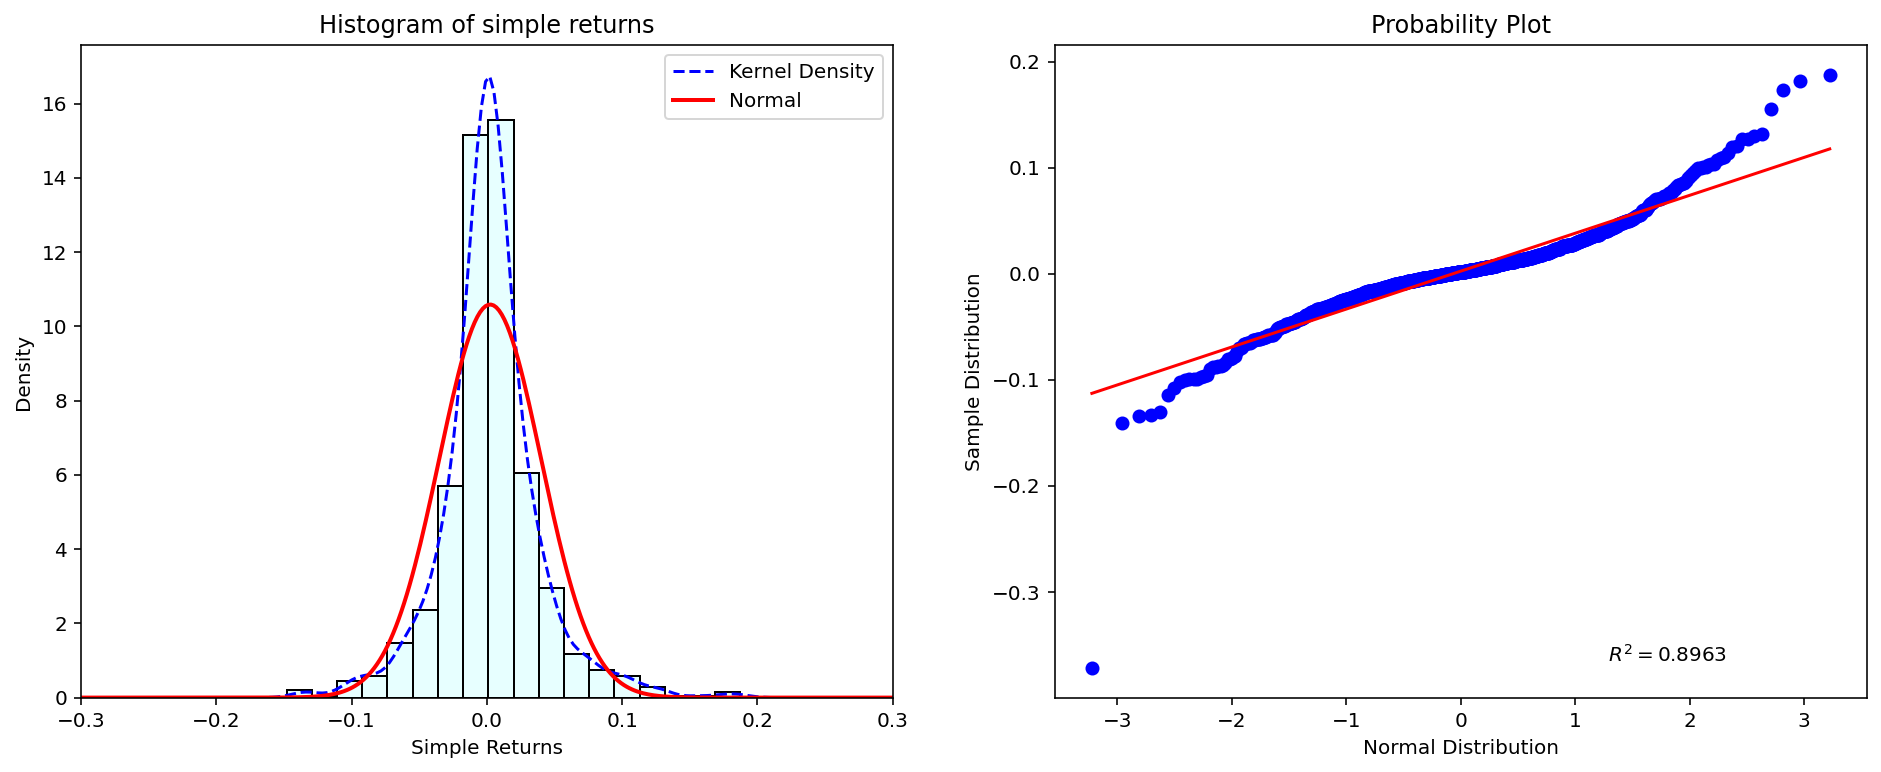

In [82]:
multiPlot("BTC-USD")

In [83]:
print("BTC distribution skewness: " + str(stats.skew(df["BTC-USD"].pct_change().iloc[1:])))
print("BTC distribution kurtosis: " + str(stats.kurtosis(df["BTC-USD"].pct_change().iloc[1:])))

BTC distribution skewness: -0.5171520410798522
BTC distribution kurtosis: 11.367661851404485


### Ethereum (ETH)

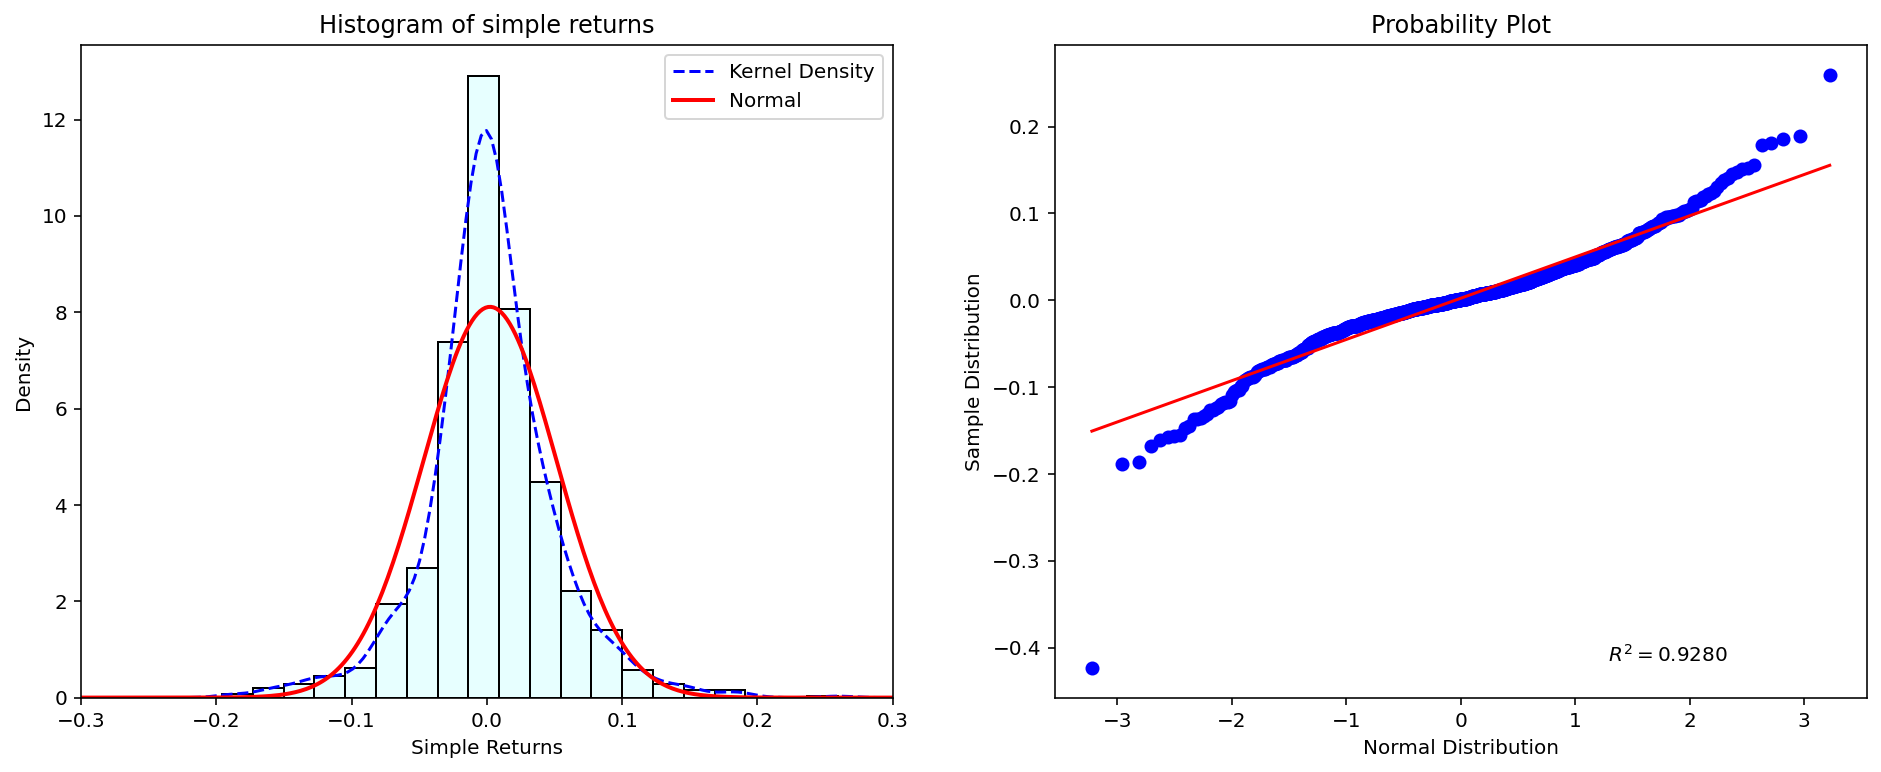

In [84]:
multiPlot("ETH-USD")

In [85]:
print("ETH distribution skewness: " + str(stats.skew(df["ETH-USD"].pct_change().iloc[1:])))
print("ETH distribution kurtosis: " + str(stats.kurtosis(df["ETH-USD"].pct_change().iloc[1:])))

ETH distribution skewness: -0.47849499150368285
ETH distribution kurtosis: 7.186776418479125


### Cardano (ADA)

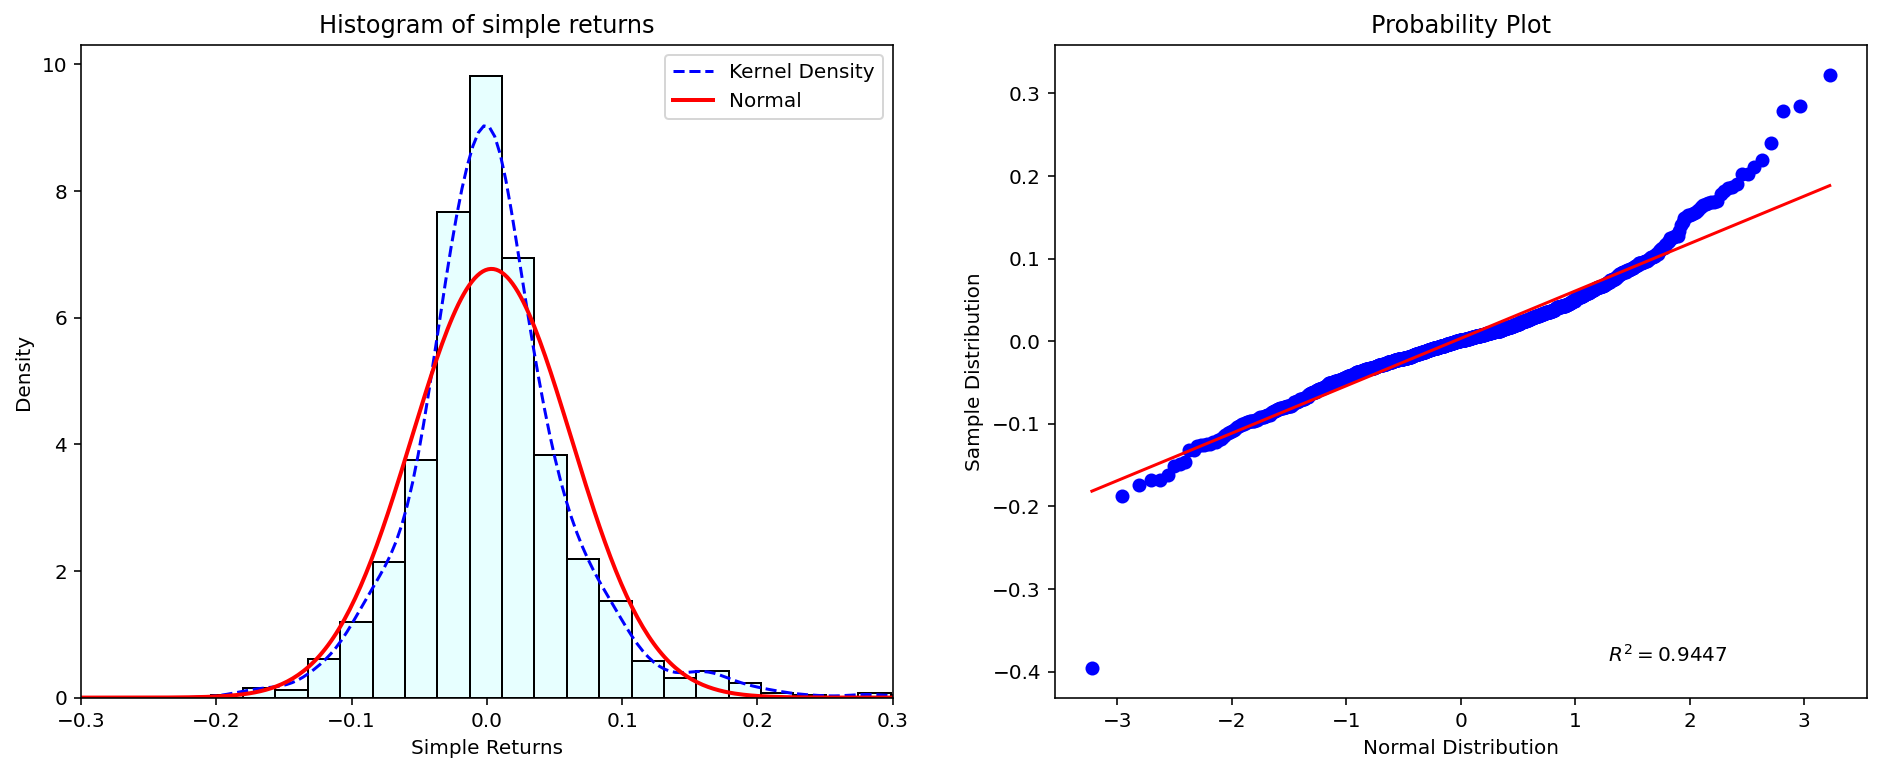

In [86]:
multiPlot("ADA-USD")

In [87]:
print("ADA distribution skewness: " + str(stats.skew(df["ADA-USD"].pct_change().iloc[1:])))
print("ADA distribution kurtosis: " + str(stats.kurtosis(df["ADA-USD"].pct_change().iloc[1:])))

ADA distribution skewness: 0.4181586282986448
ADA distribution kurtosis: 4.353328796122209


### Chainlink (LINK)

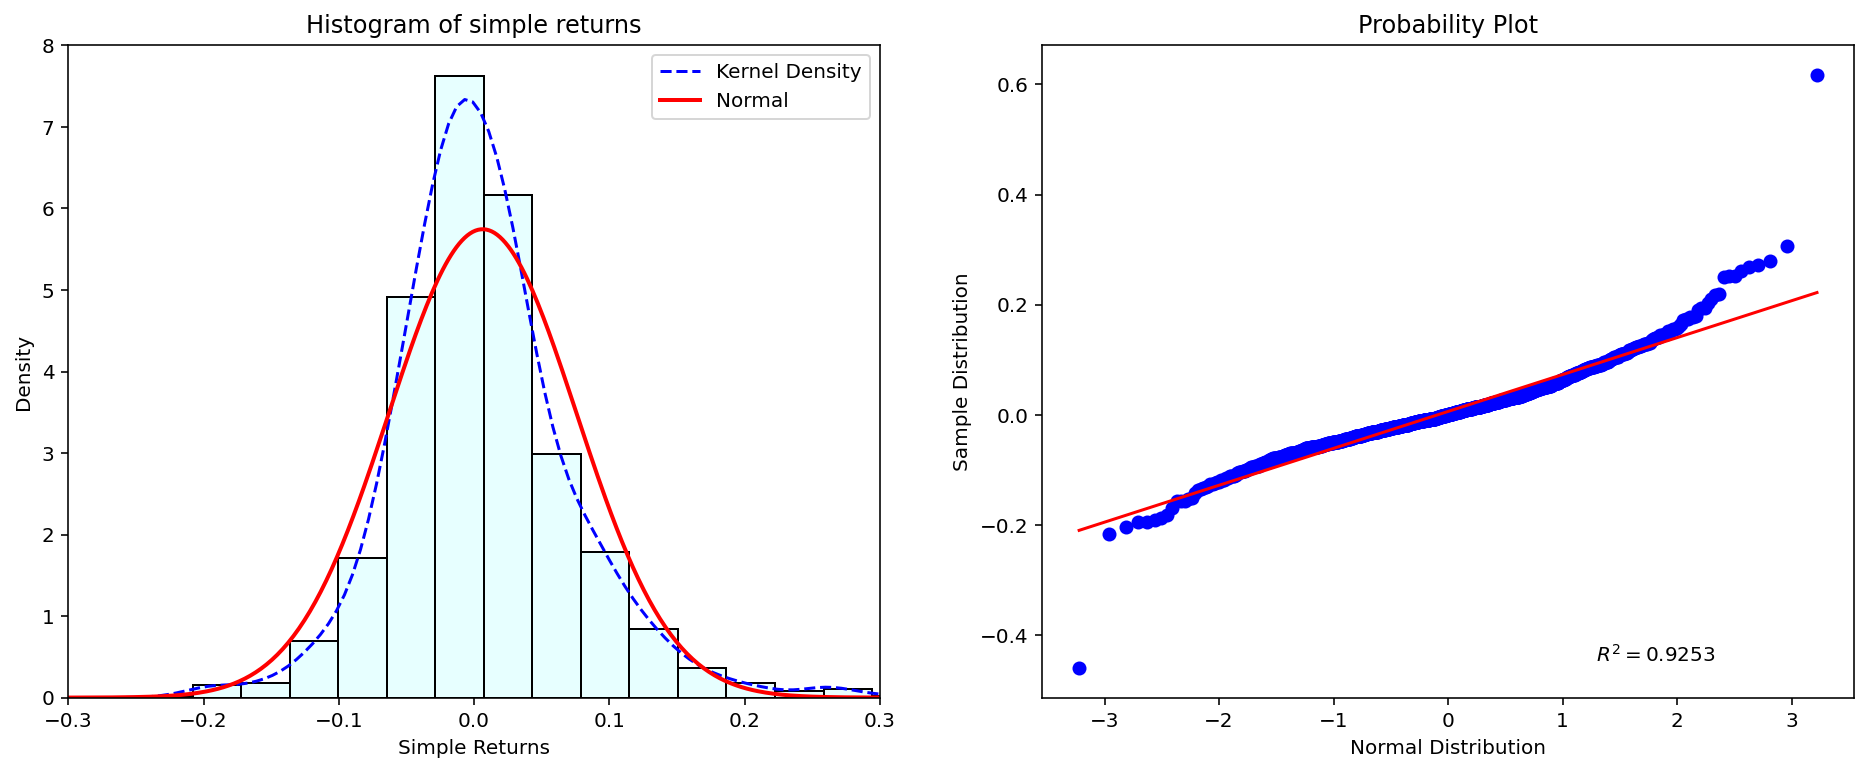

In [88]:
multiPlot("LINK-USD")

In [89]:
print("LINK distribution skewness: " + str(stats.skew(df["LINK-USD"].pct_change().iloc[1:])))
print("LINK distribution kurtosis: " + str(stats.kurtosis(df["LINK-USD"].pct_change().iloc[1:])))

LINK distribution skewness: 0.8403983531193563
LINK distribution kurtosis: 8.314158949167988


### Binance Coin (BNB)

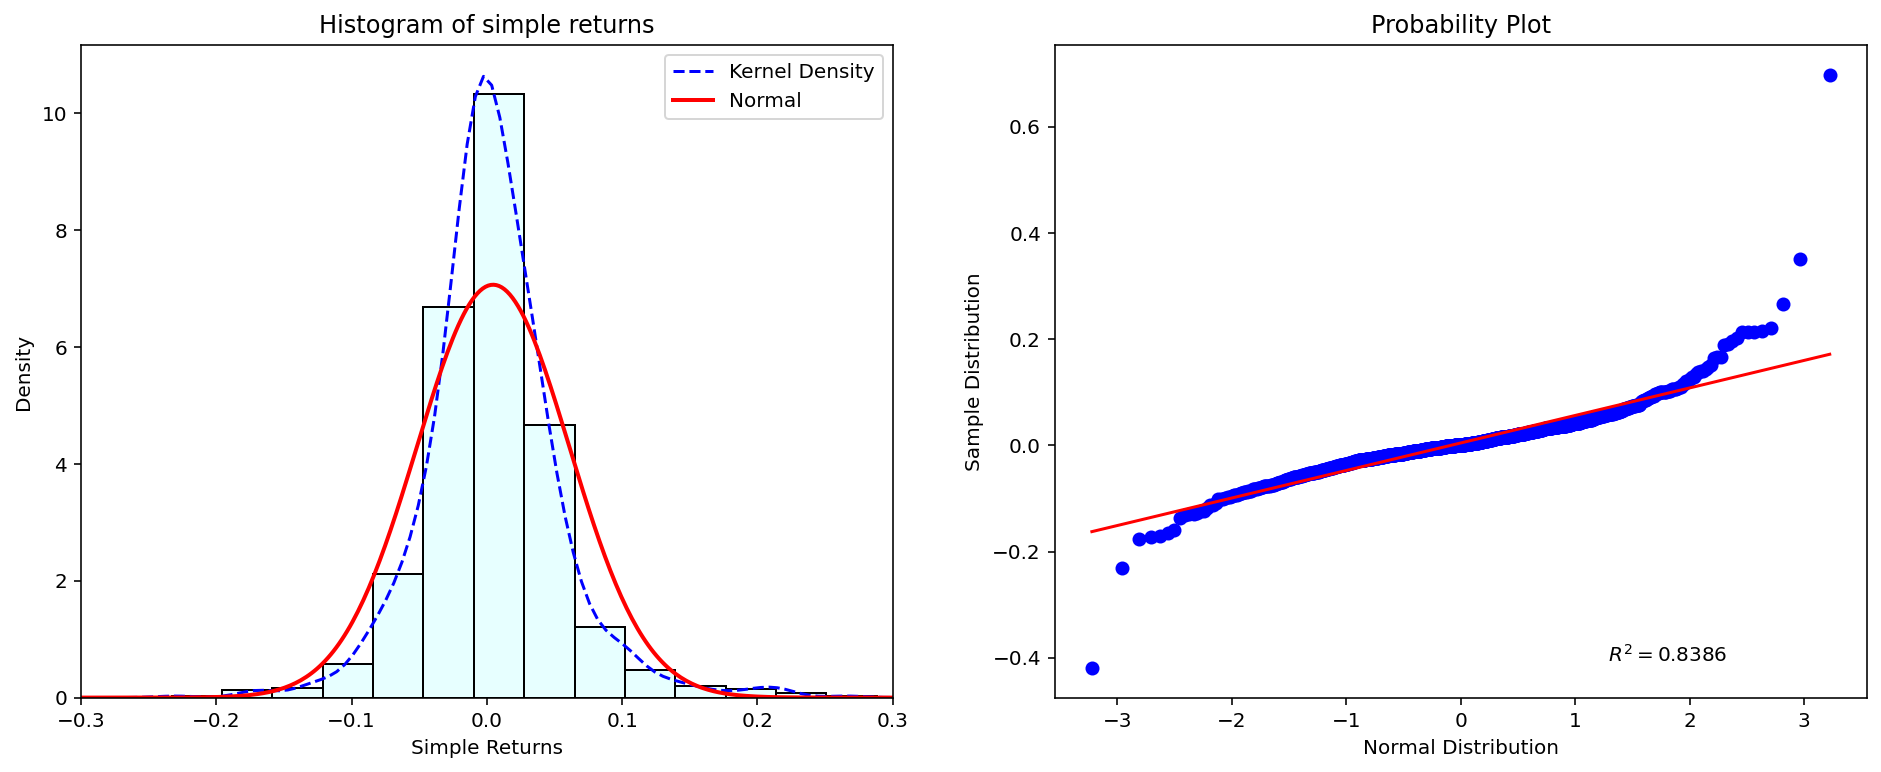

In [90]:
multiPlot("BNB-USD")

In [91]:
print("BNB distribution skewness: " + str(stats.skew(df["BNB-USD"].pct_change().iloc[1:])))
print("BNB distribution kurtosis: " + str(stats.kurtosis(df["BNB-USD"].pct_change().iloc[1:])))

BNB distribution skewness: 1.8554589497626968
BNB distribution kurtosis: 26.02921385117012


## Mean-Variance-Optimization (MVO)

We'll use the package `PyPortfolioOpt` for all our calculations regarding the MVO.

### Calculate Annual Mean Return Vector $\mu$

Calculate the annual mean returns for each asset using the geometric mean:
$\bar{r} = [(1+r_{1}) \cdot (1+r_{2}) \cdots (1+r_{n})]^{365/n} - 1$

In [92]:
from pypfopt import expected_returns
mu = expected_returns.mean_historical_return(df, compounding = True, frequency = 365)
print("Vector of mean returns:")
print(mu)

Vector of mean returns:
Symbols
BTC-USD     0.883048
ETH-USD     0.486193
ADA-USD     0.847752
LINK-USD    3.281284
BNB-USD     2.094653
dtype: float64


### Calculate Variance-Covariance Matrix $\Sigma_{r}$

In addition to the expected returns, mvo requires a risk model, some way of quantifying asset risk. We'll use the classic covariance-matrix first.

In [93]:
from pypfopt.risk_models import sample_cov
sigma = sample_cov(df)
print(sigma)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.358071  0.381590  0.375648  0.341112  0.324933
ETH-USD   0.381590  0.610104  0.563755  0.513610  0.435046
ADA-USD   0.375648  0.563755  0.875606  0.549375  0.461568
LINK-USD  0.341112  0.513610  0.549375  1.216064  0.446168
BNB-USD   0.324933  0.435046  0.461568  0.446168  0.803783


### Efficient Frontier

Computing random portfolios and efficient frontier using $\mu_{p}=\mu^{T}w$ and $\sigma^2_{p}=w^{T}\Sigma w$.

In [101]:
# generate n random portfolios for plotting
n = 20000
w = np.random.dirichlet(np.ones(len(mu)), n)
returns = w.dot(mu)
variance = np.sqrt(np.diag(w @ sigma @ w.T))
sharp_ratio = returns / variance

In [102]:
from matplotlib.gridspec import GridSpec
from pypfopt.efficient_frontier import EfficientFrontier

# tell piecharts to only show weights > 0
def my_autopct(pct):
    return ("%.0f" % pct) if pct > 0 else "" 

# function for plotting the efficient frontier
def plotEF(returns, variance, mu, sigma, labels_list):
    max_sharpe = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
    max_sharpe.max_sharpe() # maximum sharpe-ratio
    returns_ms, variance_ms, _ = max_sharpe.portfolio_performance()

    min_vola = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
    min_vola.min_volatility() # minimum volatility
    returns_mv, variance_mv, _ = min_vola.portfolio_performance()

    fig = plt.figure(figsize = (18, 8))
    gs = GridSpec(nrows = 2, ncols = 2, wspace = -0.2)
    
    ax0 = fig.add_subplot(gs[:,0])
    ax0.scatter(variance, returns, marker = ".", c = sharp_ratio, cmap = "plasma")
    ax0.scatter(variance_ms, returns_ms, marker = ".", s = 700, c = "b", label = "Maximum Sharpe-Ratio")
    ax0.scatter(variance_mv, returns_mv, marker = ".", s = 700, c = "g", label = "Minimum Volatility")
    ax0.set_title("Efficient Frontier")
    ax0.set_xlabel("Volatility")
    ax0.set_ylabel("Returns")
    ax0.legend(frameon = False, borderpad = 1.5, labelspacing = 1)
    
    # plot piechart of portfolio with minimum volatility
    ax1 = fig.add_subplot(gs[0,1])
    ef_mv = EfficientFrontier(mu, sigma)
    weights_mv = ef_mv.min_volatility()
    pd.Series(weights_mv).plot.pie(labels = labels_list, autopct = my_autopct)
    plt.ylabel("")
    plt.title("Minimum Volatility Portfolio")

    # plot piechart of portfolio with maximum sharpe-ratio
    ax2 = fig.add_subplot(gs[1,1])
    ef_ms = EfficientFrontier(mu, sigma)
    weights_ms = ef_ms.max_sharpe()
    pd.Series(weights_ms).plot.pie(labels = labels_list, autopct = my_autopct)
    plt.ylabel("")
    plt.title("Maximum Sharpe-Ratio Portfolio")

    plt.show()

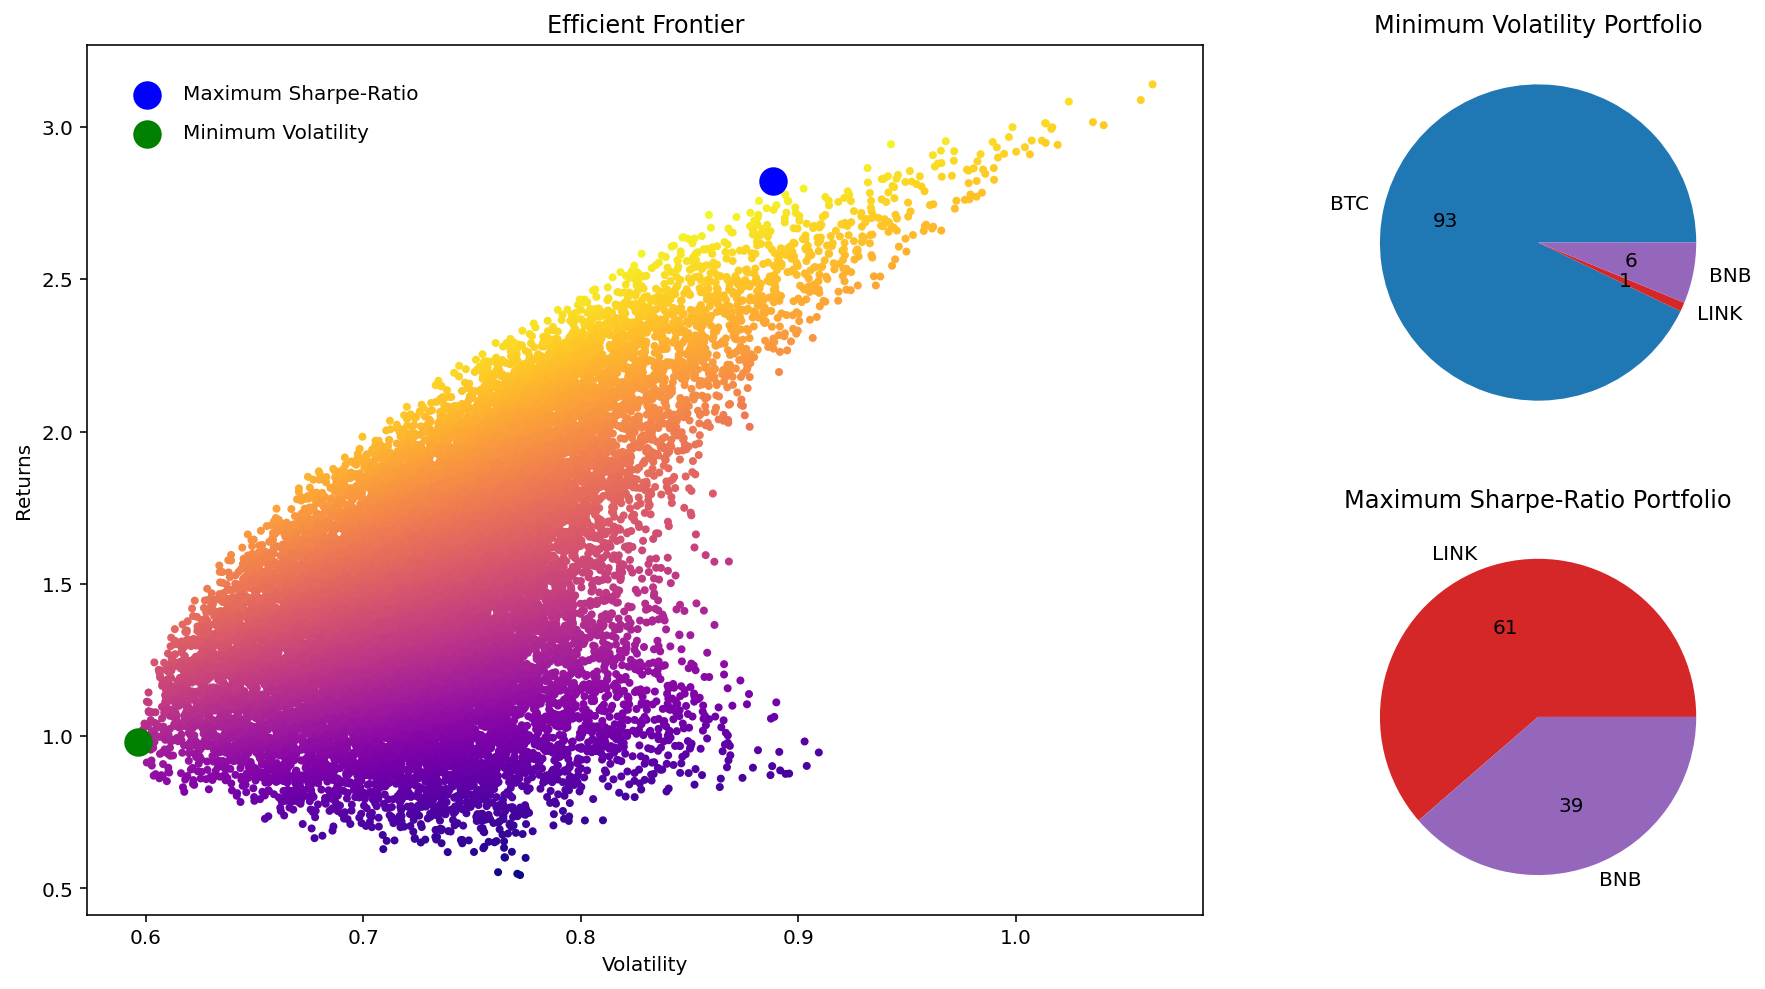

In [103]:
plotEF(returns, variance, mu, sigma, ["BTC", "ETH", "ADA", "LINK", "BNB"])

## MVO + Capital Asset Pricing Model (CAPM)

We'll use the CRIX cryptocurreny index as our benchmark data for the CAPM.

In [23]:
benchmark = pd.read_json("http://data.thecrix.de/data/crix.json")
benchmark.set_index("date", inplace = True)
print(benchmark)

                    price
date                     
2014-07-31    1000.000000
2014-08-01    1018.202717
2014-08-02    1008.772389
2014-08-03    1004.416500
2014-08-04    1004.984138
...                   ...
2021-03-14  170525.177127
2021-03-15  165539.651239
2021-03-16  156291.020042
2021-03-17  158122.757150
2021-03-18  164121.602064

[2423 rows x 1 columns]


### CAPM using benchmark data

Calculate the expected returns for each asset using the CAPM: $E[r_{i}] = r_{f} + (E[r_{m}]-r_{f})\beta_{i}$

In [24]:
mu_capm = expected_returns.capm_return(df, compounding = True, frequency = 365, market_prices = benchmark)
print("Expected returns using benchmark data:")
print(mu_capm)

Expected returns using benchmark data:
BTC-USD     0.013785
ETH-USD     0.018749
ADA-USD    -0.014989
LINK-USD   -0.002639
BNB-USD     0.039742
Name: mkt, dtype: float64


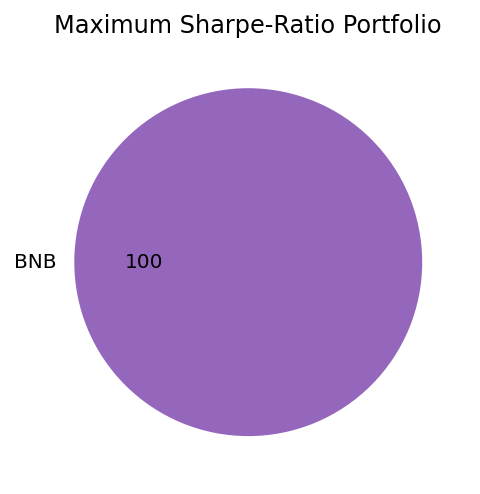

In [25]:
ef_capm = EfficientFrontier(mu_capm, sigma, weight_bounds = (0,1))
weights_capm = ef_capm.max_sharpe()
pd.Series(ef_capm.clean_weights()).plot.pie(labels = ["BTC", "ETH", "ADA", "LINK", "BNB"], autopct = my_autopct)
plt.ylabel("")
plt.title("Maximum Sharpe-Ratio Portfolio");

### CAPM without benchmark data

Not using any market data results in the model using the given returns as a proxy for $E[r_{m}]$.

In [104]:
mu_capm = expected_returns.capm_return(df, compounding = True, frequency = 365)
print("Expected returns not using benchmark:")
print(mu_capm)

Expected returns not using benchmark:
Symbols
BTC-USD     1.255301
ETH-USD     1.756502
ADA-USD     1.979690
LINK-USD    2.146383
BNB-USD     1.733890
Name: mkt, dtype: float64


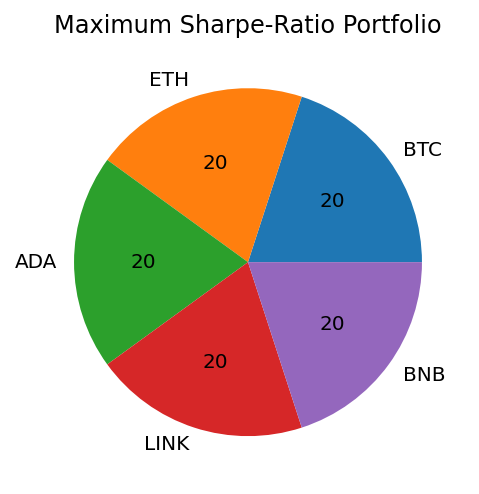

In [105]:
ef_capm = EfficientFrontier(mu_capm, sigma, weight_bounds = (0,1))
weights_capm = ef_capm.max_sharpe()
pd.Series(ef_capm.clean_weights()).plot.pie(labels = ["BTC", "ETH", "ADA", "LINK", "BNB"], autopct = my_autopct)
plt.ylabel("")
plt.title("Maximum Sharpe-Ratio Portfolio");

## MVO - Using Different Risk Models

### Ledoit-Wolf Shrinkage

In [98]:
from pypfopt.risk_models import CovarianceShrinkage
sigma_lw = CovarianceShrinkage(df).ledoit_wolf()
print(sigma_lw)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.366423  0.373252  0.367439  0.333658  0.317832
ETH-USD   0.373252  0.612949  0.551435  0.502386  0.425539
ADA-USD   0.367439  0.551435  0.872649  0.537370  0.451482
LINK-USD  0.333658  0.502386  0.537370  1.205667  0.436418
BNB-USD   0.317832  0.425539  0.451482  0.436418  0.802395


In [108]:
variance_lw = np.sqrt(np.diag(w @ sigma_lw @ w.T))
sharp_ratio = returns / variance_lw

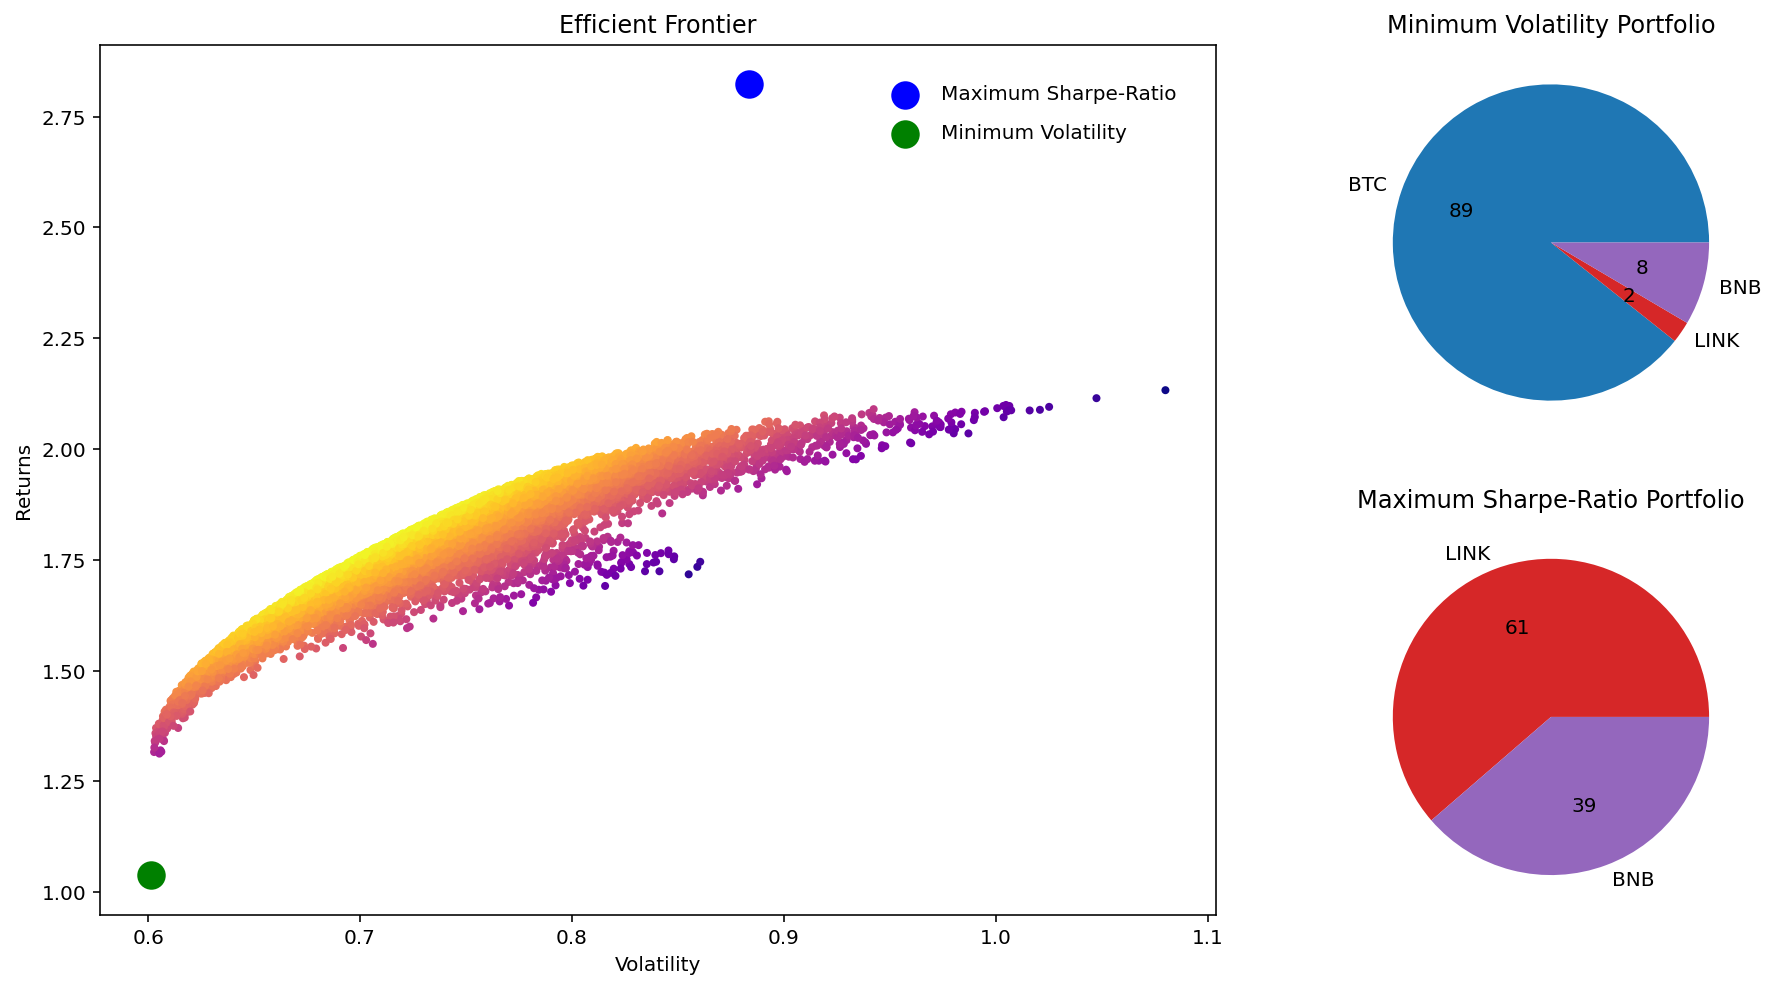

In [109]:
plotEF(returns, variance_lw, mu, sigma_lw, ["BTC", "ETH", "ADA", "LINK", "BNB"])

### Exponentially-Weighted Covariance Matrix

In [110]:
from pypfopt.risk_models import exp_cov
sigma_exp = exp_cov(df)
print(sigma_exp)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.479682  0.427700  0.340165  0.387115  0.530521
ETH-USD   0.427700  0.751145  0.559563  0.633098  0.561569
ADA-USD   0.340165  0.559563  1.595264  0.672344  0.647866
LINK-USD  0.387115  0.633098  0.672344  1.241137  0.695135
BNB-USD   0.530521  0.561569  0.647866  0.695135  2.558599


In [111]:
variance_exp = np.sqrt(np.diag(w @ sigma_exp @ w.T))
sharp_ratio = returns / variance_exp

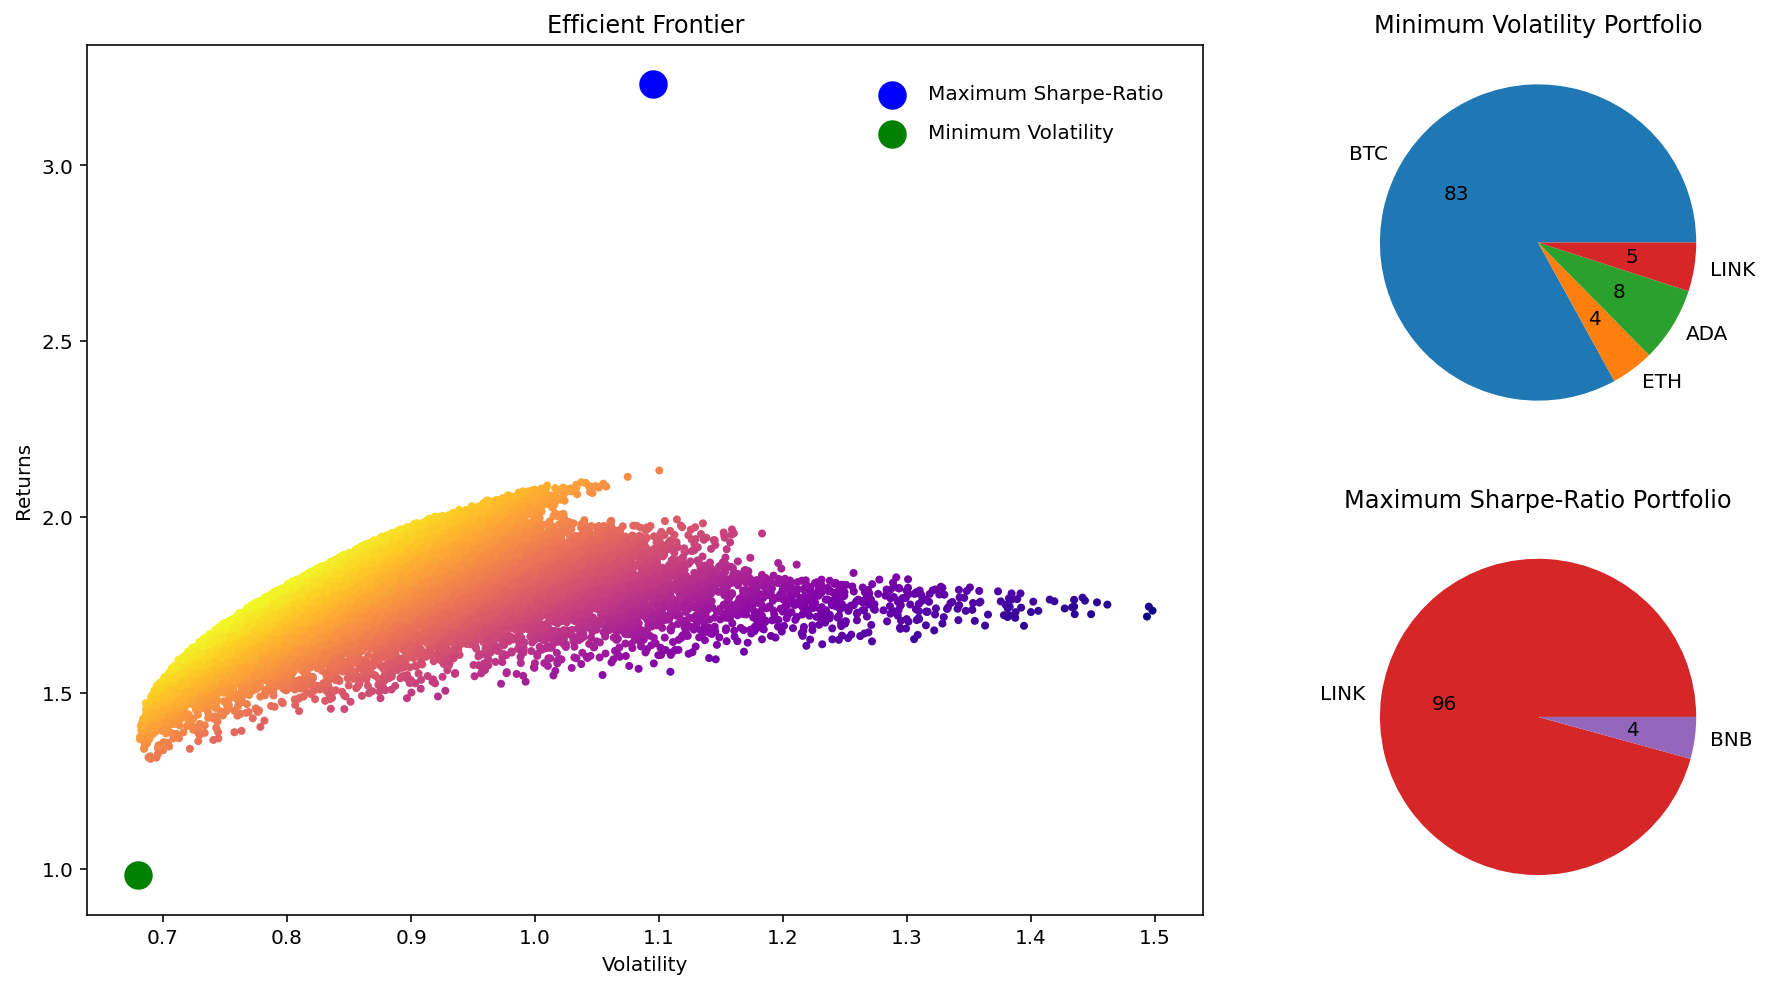

In [112]:
plotEF(returns, variance_exp, mu, sigma_exp, ["BTC", "ETH", "ADA", "LINK", "BNB"])

## Black-Litterman Allocation